# <center>Simulating Counting Processes with Python</center>

This notebook documents my journey to understand and simulate counting processes. It covers homogeneous and inhomogeneous Poisson processes, as well as Hawkes processes with various conditional intensities.

The simulation methods covered here are based on *Ogata's method of thinning*, detailed [here](https://pdfs.semanticscholar.org/9fb1/0a3c2dcec939784ce208e0e7e7fda4be895c.pdf). The simulation algorithms in Ogata's paper are the most straightforward to understand, but are not the most efficient.

Feel free to contact me at gfeldman@tpg.com.au with any questions, comments or criticism.


### Homogeneous Poisson Process
We will first simulate a homogeneous Poisson process. This is fairly simple. It proceeds as follows:

   Step 1. Take the pdf (probability density function) of the time between events (where $\lambda$ is the rate of events):
    
$$ f(t) = \lambda e^{- \lambda t} $$

   Step 2. Find the associated cdf (cumulative distribution function).
    
$$ F(t) = \int_{0}^{t} \lambda e^{- \lambda s} ds = 1 - e^{- \lambda t} $$

   Step 3. Find the inverse of the cdf.
    
$$ F^{-1}(p(t<T)) = -\frac{ln(1-p(t<T))}{\lambda} $$

   Step 4. Generate a random, uniformly distributed number $U$, between 0 and 1, to plug into $F^{-1}$.

   Step 5. Use the inverse cdf to get a corresponding time since last event.
   
$$ \Delta t = -\frac{ln(U)}{\lambda} $$
    
   Step 6. Repeat 4. and 5. until a sufficient number of interarrival times have been generated.

This process will yield a sequence of time between events, which can be converted into arrival times or total counts.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

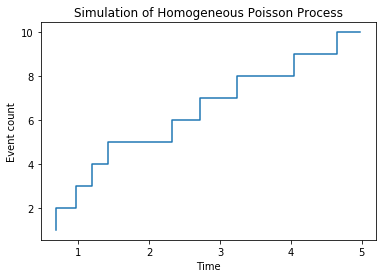

In [9]:
# Play with these parametres to alter the rate time and number of simulated events.
_lambda = 2
n = 10

# Do the simulation.
U = np.random.uniform(0,1,n)
interarrival_times = -np.log(U)/_lambda
arrival_times = np.cumsum(interarrival_times)
counts = np.arange(n)+1

# Plot the results.
plt.step(arrival_times, counts)
plt.title("Simulation of Homogeneous Poisson Process")
plt.xlabel("Time")
plt.ylabel("Event count")
plt.show()

### Inhomogeneous Poisson Process

The process is easy enough for a homogeneous Poisson process, but when the intensity $\lambda$ is time-varying (i.e. a function of $t$, $\lambda(t)$), calculating $F^{-1}$ can become a very difficult (or impossible) task. Poisson processes with time-varying intensities are referred to as inhomogeneous.

Instead of sampling directly from the inhomogeneous process, we will sample from a homogeneous Poisson process with $\lambda_{homogeneous}>\lambda(t)$ for all $t$. We then probabilistically reject events based on a comparison of $\lambda_{homogeneous}$ and $\lambda(t)$. This is possible due to the fact that we can easily evaluate $\frac{\lambda_{homogeneous}}{\lambda(t)}$ for any value of t.

The trick is to generate another random, uniformly distributed number $U_{1}$,between 0 and 1, each time we generate an event and reject that event whenever $U_{1}>\frac{\lambda_{homogeneous}}{\lambda(t)}$. This accounts for "extra" events that are generated in periods where $\lambda_{homogeneous}$ is higher than $\lambda(t)$.

For this example, we will assume

$$\lambda(t) = \beta sin(\alpha t) + |\beta| $$

In [11]:
def lambda_t(t, beta=1., alpha=0.5):
    
    return beta*np.sin(alpha*t)+np.abs(beta)

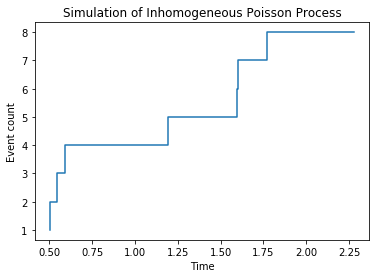

In [13]:
# Play with these parametres to alter the rate time and number of simulated events.
beta = 1.
alpha = 0.5

# We need to choose lambda to be greater than lambda_t at all times
_lambda = 2*beta
n = 10

# Sample from homogeneous Poisson process.
U = np.random.uniform(0,1,n)
interarrival_times = -np.log(U)/_lambda
arrival_times = np.cumsum(interarrival_times)

# Do rejection sampling.
thresholds = lambda_t(arrival_times)/_lambda
U_1 = np.random.uniform(0,1,n)
keep = U_1<thresholds

arrival_times = arrival_times[keep]
counts = np.arange(len(arrival_times))+1

# Plot the results.
plt.step(arrival_times, counts)
plt.title("Simulation of Inhomogeneous Poisson Process")
plt.xlabel("Time")
plt.ylabel("Event count")
plt.show()

## <center>Simulating Hawkes Processes</center>

Hawkes processes are a generalisation of Poisson processes that allow past events to increase the intensity. The method of simulation is conceptually the same as for an inhomogeneous Poisson process, but we now need to account for a more complex intensity, $\lambda(t|history)$, that is dependant on past events. The main implication is that we need to be a bit more careful in choosing our $\lambda_{homogeneous}$, which requires us to generate arrival times one by one, in contrast to the vectorized examples above.

The reason we need to be more careful about sampling is that for any given $\lambda_{homogeneous}$, it is possible for a string of excitation events to push $\lambda(t|history)$ above $\lambda_{homogeneous}$ and ruin our rejection sampling process.

The general procedure will be to restrict our samples to certain time frames (rejecting sampled times outside of it) in order to allow us to calculate $max(\lambda(t|history))$ over a given time frame. This will allow us to choose an appropriate intensity for our homogeneous Poisson process. Note that we may have had to do this in the previous example if our $\lambda(t)$ had been unbounded, though this would not represent a realistic scenario. 

### Hawkes Process with Exponentially Decaying Excitation

For the first example, we will use an exponentially decaying $\lambda(t|history)$

$$\lambda(t|history) = \lambda_{base} + \int_{-\inf}^{t_{current}} \alpha \beta exp^{- \beta (t_{current}-t)} dN_{t}$$

We can take advantage of the fact that, in the time just after an event and just before the next event, $\lambda(t|history)$ will be greatest at the start of the time interval. Hence, for an interval $[t_{N_{k}}, t_{N_{k+1}})$, we set $\lambda_{homogeneous}=\lambda(t_{N_{k}}|history)$.

For this specific example, do not need to restrict each point simulation to a specific interval as our conditional intensity possesses proporties which allow us to choose $\lambda_{homogeneous}$ without fear of $\lambda(t|history)$ exceeding it.

In [39]:
def lambda_t(cur_time, hist, base_rate=2., alpha=20, beta=1.):
    
    if len(hist)==0:
        return base_rate
    
    else:
        
        hist = np.cumsum(hist)
        exp_arg = -beta*(cur_time-hist)
        intensity = base_rate + np.sum(alpha*beta*np.exp(exp_arg))
        return intensity

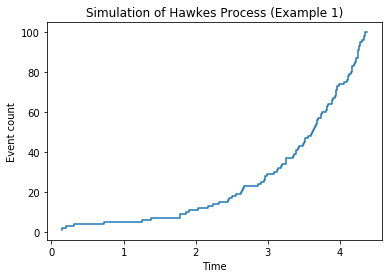

In [123]:
# Play around with these parameters.
base_rate = 2
N = 100
alpha = 2.
beta = 1.

# Simulate the process.
hist = np.array([])
time = 0
n=0

while n < N:
    
    _lambda = lambda_t(time, hist, base_rate, alpha, beta)
    
    U = np.random.uniform()
    interarrival_time = -np.log(U)/_lambda
    
    _lambda_hist = lambda_t(interarrival_time, hist, base_rate, alpha, beta)
    
    if np.random.uniform()<_lambda_hist/_lambda:
        
        hist = np.append(hist, interarrival_time)
        time += interarrival_time
        n+=1
  
hist = np.cumsum(hist)
counts = np.arange(len(hist))+1
        
# Plot the results.
plt.step(hist, counts)
plt.title("Simulation of Hawkes Process (Example 1)")
plt.xlabel("Time")
plt.ylabel("Event count")
plt.show()

### Hawkes Process with Exponentially Increasing Excitation

For the second example, we will use an exponentially increasing $\lambda(t|history)$

$$\lambda(t|history) = \lambda_{base} + \int_{-\inf}^{t} \alpha \beta exp^{\beta (t_{current}-t)} dN_{t}$$

In this example, for a fixed interval $[t_{current},t_{current}+\Delta t)$, we know that $\lambda(t|history)$ will be greatest at $t_{current}+\Delta t$. Hence we set 

$$\lambda_{homogeneous} = \lambda(t_{current}+\Delta t|history)$$

in each interval.

We now need to restrict simulated arrival times to the interval we are operating in, as $\lambda_{homogeneous}$ is not necesarrily greater than or equal to $\lambda(t|history)$ outside of this interval. As in the case of an inhomogeneous Poisson process with unbounded intensity, this scenario is also not realistic *unless* there is another process that causes $\lambda(t|history)$ to become bounded.

*Note: if you're following along with Ogata's paper, be aware that algorithm 3, step 8 should include "set j = j+1" and "if $j = N_{*}^{i}$, go to step 11".*

In [116]:
# Loop version of homogeneous Poisson process simulation
def homog_Poisson(rate, T):
    
    t = 0
    arrival_times = []
    
    while t<T:
        
        U = np.random.uniform()
        interarrival_time = -np.log(U)/rate
        t+=interarrival_time
        if t<T:
            arrival_times.append(t)
        
    return np.array(arrival_times)

/home/greg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


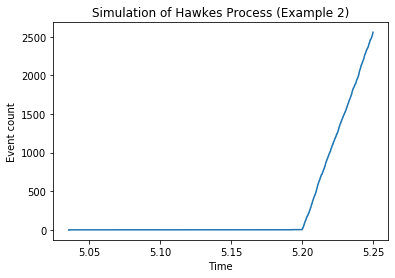

In [125]:
base_rate = 2.
delta_time = (1/base_rate)/10
cur_time = 0
hist = np.array([])
n = 20
max_time = 10

while len(hist)<n:

    # Set rate for homogeneous Poisson process and get arrival times for
    # current time interval
    _lambda = lambda_t(cur_time+delta_time, hist, base_rate, alpha, beta)
    arrival_times = homog_Poisson(_lambda, delta_time) + cur_time
    
    if len(arrival_times)==0:
        cur_time+=delta_time
    
    for j in range(len(arrival_times)):
    
        U_j = np.random.uniform()
        lambda_hist = lambda_t(arrival_times[j], hist, base_rate, alpha, beta)
        threshold = lambda_hist/_lambda
    
        if U_j<threshold:

            hist = np.append(hist, arrival_times[j])
            
    cur_time+=delta_time
    if cur_time>max_time:
        break
    
counts = np.arange(len(hist))
        
# Plot the results.
plt.step(hist, counts)
plt.title("Simulation of Hawkes Process (Example 2)")
plt.xlabel("Time")
plt.ylabel("Event count")
plt.show()